In [9]:
import pandas as pd
import duckdb
import glob

import matplotlib.pyplot as plt
import seaborn as sns

# Assay sizes

In [2]:
# List of all excel files in the directory
all_files = glob.glob("/Users/sethhowes/Desktop/FS-Tox/data/raw/toxvaldb/*.xlsx")

# Empty list to hold dataframes
df_list = []

# Loop through all files
for file in all_files:
    # Read each excel file as a pandas dataframe
    df = pd.read_excel(file)
    # Append the dataframe to the list
    df_list.append(df)

# Concatenate all dataframes in the list
final_df = pd.concat(df_list, ignore_index=True)

In [5]:
final_df.shape

(905858, 68)

In [4]:
final_df.columns

Index(['dtxsid', 'casrn', 'name', 'source', 'subsource', 'qc_status',
       'risk_assessment_class', 'human_eco', 'toxval_type',
       'toxval_type_original', 'toxval_subtype', 'toxval_type_supercategory',
       'toxval_numeric_qualifier', 'toxval_numeric', 'toxval_units',
       'toxval_numeric_original', 'toxval_units_original', 'study_type',
       'study_type_original', 'study_duration_class',
       'study_duration_class_original', 'study_duration_value',
       'study_duration_value_original', 'study_duration_units',
       'study_duration_units_original', 'species_id', 'species_original',
       'common_name', 'latin_name', 'ecotox_group', 'habitat', 'strain',
       'strain_group', 'strain_original', 'sex', 'sex_original', 'generation',
       'lifestage', 'exposure_route', 'exposure_route_original',
       'exposure_method', 'exposure_method_original', 'exposure_form',
       'exposure_form_original', 'media', 'media_original', 'critical_effect',
       'critical_effect_ori

The relevant features that I want to group by are:
- `common_name` - species
- `source` - dataset the record originated from
- `toxval_type` - outcome score type
- `toxval_units` - units for measuring exposure
- `study_type` - basic description of assay
- `exposure_route` - route of administration

All of these columns should be in a decent state apart from `toxval_type`. The different values in this column should be combined if similar (e.g. LD and LC)

In [6]:
final_df["toxval_type"].value_counts()

toxval_type
LC50                  177813
LD50                  132442
NOEC                  109518
LOEC                   75529
NOAEL                  73615
                       ...  
LT50@ 26.62 AI mgL         1
LT50@ 29.12 AI mgL         1
LT50@ 0.688 AI mgL         1
LT50@ 97.84 AI mgL         1
STI                        1
Name: count, Length: 1974, dtype: int64

In [32]:
grouped = final_df.groupby(['common_name', 'source', 'toxval_type', 'toxval_units', 'study_type', 'exposure_route']).size().reset_index(name='counts')

In [33]:
grouped

,common_name,source,toxval_type,toxval_units,study_type,exposure_route,counts
0,Great Fruit-eating Bat,HPVIS,EC50,mg/L,acute,-,4
1,Great Fruit-eating Bat,HPVIS,EC50,mg/L,chronic,-,1
2,Great Fruit-eating Bat,HPVIS,EC50,ug/L,acute,-,1
3,Great Fruit-eating Bat,HPVIS,LC0,mg/L,acute,-,16
4,Great Fruit-eating Bat,HPVIS,LC100,mg/L,acute,-,15
...,...,...,...,...,...,...,...
36722,whitewater crowfoot,ECOTOX,EC50,mg/m3,physiology,aqueous,1
36723,whitewater crowfoot,ECOTOX,EC50,mg/m3,population,aqueous,2
36724,whitewater crowfoot,ECOTOX,EC90,mg/m3,physiology,aqueous,1
36725,whitewater crowfoot,ECOTOX,LOEL,mg/m3,growth,aqueous,1


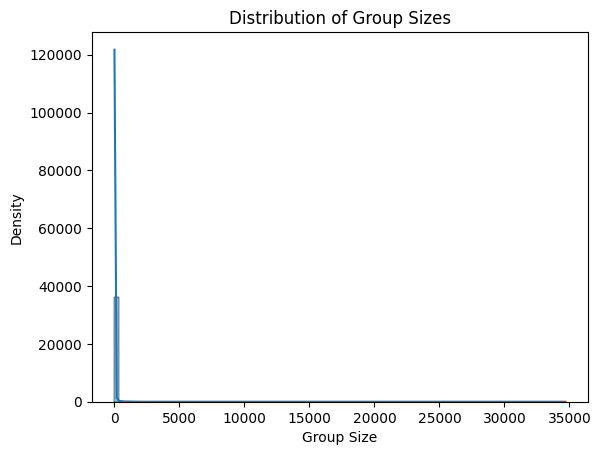

In [34]:
# Create a histogram/density plot
sns.histplot(grouped['counts'], bins=100, kde=True)

plt.title('Distribution of Group Sizes')
plt.xlabel('Group Size')
plt.ylabel('Density')
plt.show()

In [35]:
grouped["counts"].median()

2.0

In [37]:
grouped_selection = grouped[grouped["counts"] < 100]

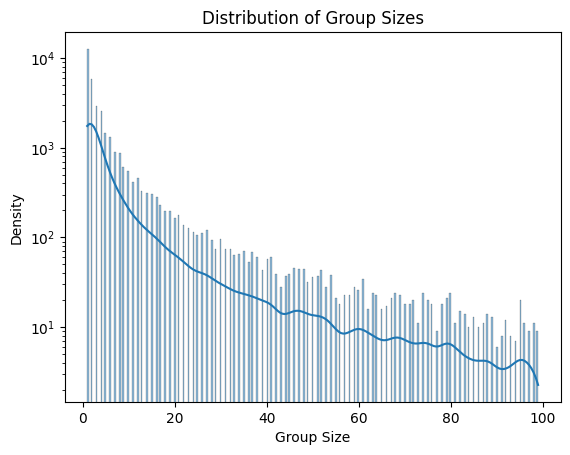

In [38]:
# Create a histogram/density plot
sns.histplot(grouped_selection['counts'], kde=True)

plt.title('Distribution of Group Sizes')
plt.xlabel('Group Size')
plt.ylabel('Density')

# Log scale the y-axis
plt.yscale('log')

plt.show()

I want to explore why there is such a long right tail of the distribution.

In [66]:
grouped[grouped["counts"] > 500].sort_values(by="counts", ascending=False)

,common_name,source,toxval_type,toxval_units,study_type,exposure_route,counts
26216,Rat,ECHA IUCLID,LD50,mg/kg,acute,oral,34685
18882,Mouse,ChemIDplus,LD50,mg/kg,acute,oral,27621
27859,Rat,TEST,LD50,mg/kg,acute,oral,13060
25927,Rat,ChemIDplus,LD50,mg/kg,acute,oral,12920
14857,Human (RA),DOD,MEG,mg/m3,acute,inhalation,10312
...,...,...,...,...,...,...,...
24514,Rabbit,HPVIS,LD50,mg/kg,acute,dermal,504
13005,Green Algae,ECOTOX,NOEL,mg/m3,population,aqueous,504
6950,Common Carp,ECOTOX,NOEC,mg/m3,biochemistry,aqueous,502
14242,"Harlequinfish, Red Rasbora",ECOTOX,LC50,mg/m3,mortality,aqueous,502


In [88]:
(grouped["counts"] > 24).sum()

3650

# Unique molecules
I now want to check the number of unique molecules that I have in this dataset

In [99]:
# Get records that belong to a group of greater than 10 members
bigger_groups = final_df.groupby(['common_name', 'source', 'toxval_type', 'toxval_units', 'study_type', 'exposure_route']).filter(lambda x: len(x) >= 10)

In [101]:
len(bigger_groups["dtxsid"].unique())

47204